In [58]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import time
from datetime import datetime, timedelta
from dateutil import tz

import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats

sns.set(style="ticks", color_codes=True)

#import warnings
#warnings.filterwarnings('ignore')

In [43]:
# base path with subfolders for each pitcher of interest
basepath = 'data/pbp_files'

# list of years to clean and merge play-by-play data
years = ['2016', '2017', '2018']

# list of pitchers of interest
pitchers = ['aaron_nola', 'carlos_carrasco', 'carlos_martinez', 'chris_archer', 'chris_sale', 
            'clayton_kershaw', 'corey_kluber', 'dallas_keuchel', 'david_price', 'gerrit_cole',
            'jacob_degrom', 'jake_arrieta', 'jose_quintana', 'marcus_stroman', 'justin_verlander', 
            'max_scherzer', 'michael_fulmer', 'stephen_strasburg', 'yu_darvish', 'zack_greinke']

In [44]:
def convert_dtypes(df, cols_list=[]):
    """
    converts numerical or object data types to dtype
    returns dataframe with converted data types
    """
    for col in cols_list:
        if col in df.columns:
            if df[col].dtype == 'int64' or df[col].dtype == 'float64':
                df[col] = df[col].astype(np.int8)
            elif df[col].dtype == 'object':
                df[col] = df[col].astype('category')
    return df

In [45]:
def merge_dfs(basepath, years, pitchers, use_cols=[]):
    """
    iterate through list of pitchers for each year in list to open play-by-play file
    then call clean_dfs() to merge de-nest and merge play-by-play data into a single csv
    
    Note: some pitchers pitched during a double-header (two games on same day) so some 
          play-by-play files are skipped if pitcher of interest did not pitch the game
    
    returns true if completed without errors 
    """
    # path to pitcher_ids.csv file
    pitcher_ids_path = 'data/pitcher_logs/pitcher_ids.csv'
    # open pitcher_ids.csv file, set 'id' as index
    df_pitcher_ids = pd.read_csv(pitcher_ids_path, index_col='id')
    
    filelist = []
    
    for year in years:
        for pitcher in pitchers:         
            file_path = basepath + '/' + year + '/merged_by_player/' + pitcher + '_' + year + '_merged_games.csv'
            f_name, l_name = pitcher.split(sep='_')
            filelist.append(file_path)
    
    first_file = filelist.pop(0)
    if len(use_cols)==0:
        df_first = pd.read_csv(first_file)
    else:
        df_first = pd.read_csv(first_file, usecols=use_cols)
    
    ## compare memory usage of dataframe BEFORE and AFTER converting data types ##
    # store total memory usage and number of files
    tot_orig_mem = tot_new_mem = tot_num_files = 0
    # list of columns with data types that should be converted, if present in dataframe
    list_cnvrt_cols = ['half', 'inning', 'pitcher.hitter_hand', 'hit_type', 'pitcher.pitcher_hand', 
                       'outcome_id', 'count.balls', 'count.outs', 'count.strikes', 'pitcher.pitch_type', 
                       'count.pitch_count', 'pitcher.pitch_speed', 'pitcher.pitch_count', 'day', 'month']
    
    # check memory usage of dataframe BEFORE converting dtypes
    original_mem = round(sum((df_first.memory_usage(deep=True)/1024)/1024), 2)
    tot_orig_mem += original_mem
    # convert datatypes
    df_merged = convert_dtypes(df_first, list_cnvrt_cols)
    # check memory usage of dataframe AFTER converting dtypes and compute difference
    new_mem = round(sum((df_merged.memory_usage(deep=True)/1024)/1024), 2)
    tot_new_mem += new_mem
    diff_mem = round(original_mem - new_mem,2)
    
   # print("Memory usage BEFORE converting data types: {} mb".format(original_mem))
   # print("Memory usage AFTER converting data types: {} mb".format(new_mem))
   # print("Memory usage recovered: {} mb".format(diff_mem))
   # print("file: ", first_file, '\n')
    
    for file in filelist:
        if len(use_cols)==0:
            # open merged_games.csv file for each player
            df_temp = pd.read_csv(file)
            
            # check memory usage of dataframe BEFORE converting dtypes
            original_mem = round(sum((df_temp.memory_usage(deep=True)/1024)/1024), 2)
            tot_orig_mem += original_mem
            # convert datatypes
            df_temp_cnvrt = convert_dtypes(df_temp, list_cnvrt_cols)
            # check memory usage of dataframe AFTER converting dtypes and compute difference
            new_mem = round(sum((df_temp_cnvrt.memory_usage(deep=True)/1024)/1024), 2)
            tot_new_mem += new_mem
            diff_mem = round(original_mem - new_mem,2)
        else:
            # open merged_games.csv file for each player
            df_temp = pd.read_csv(file, usecols=use_cols)
            
            # check memory usage of dataframe BEFORE converting dtypes
            original_mem = round(sum((df_temp.memory_usage(deep=True)/1024)/1024), 2)
            tot_orig_mem += original_mem
            # convert datatypes
            df_temp_cnvrt = convert_dtypes(df_temp, list_cnvrt_cols)
            # check memory usage of dataframe AFTER converting dtypes and compute difference
            new_mem = round(sum((df_temp_cnvrt.memory_usage(deep=True)/1024)/1024), 2)
            tot_new_mem += new_mem
            diff_mem = round(original_mem - new_mem,2)
        
       # print("Memory usage BEFORE converting data types: {} mb".format(original_mem))
       # print("Memory usage AFTER converting data types: {} mb".format(new_mem))
       # print("Memory usage recovered: {} mb".format(diff_mem))
       # print("file: ", file, '\n')
            
        df_merged = pd.concat([df_merged, df_temp_cnvrt], ignore_index=True, sort=False)
    
    tot_diff_mem = round(tot_orig_mem - tot_new_mem, 2)
    
    print("\n\n\tTotal memory usage BEFORE converting data types: {} mb".format(round(tot_orig_mem,2)))
    print("\tTotal memory usage AFTER converting data types: {} mb".format(round(tot_new_mem,2)))
    print("\tTotal Memory usage recovered: {} mb\n\n".format(tot_diff_mem))
    
    return df_merged

In [5]:
cols_list = ['date', 'half', 'inning', 'count.pitch_count', 'count.balls', 'count.strikes', 'count.outs', 
             'pitcher.hitter_hand', 'pitcher.first_name', 'pitcher.last_name', 'pitcher_id', 
             'pitcher.pitch_count', 'pitcher.pitch_speed', 'pitcher.pitch_type', 
             'pitcher.pitch_zone', 'pitcher.pitcher_hand', 'outcome_id']

# call to make/merge play-by-play data into single dataframe and write to csv
#df = merge_dfs(basepath, years, pitchers, cols_list)
df = merge_dfs(basepath, years, pitchers)



	Total memory usage BEFORE converting data types: 305.47 mb
	Total memory usage AFTER converting data types: 240.26 mb
	Total Memory usage recovered: 65.21 mb




In [6]:
# cols = ['runner_3.ending_base', 'runner_3.out', 'runner_3.outcome_id', 'runner_3.starting_base', 
#         'runner_2.ending_base', 'runner_2.out', 'runner_2.outcome_id', 'runner_2.starting_base', 
#         'runner_1.ending_base', 'runner_1.out', 'runner_1.outcome_id', 'runner_1.starting_base', 
#         'year', 'pitcher.pitch_type', 'pitcher.pitch_speed', 'outcome_id', 'pitcher_id']

# df_runners = df[cols]

In [7]:
# outcome_col = ['aDAD4', 'aFCAD4', 'aHR', 'aKLAD4', 'aKSAD4', 'aROEAD4', 'aSAD4', 'aSBAD4', 'aSFAD4', 'aTAD4']
# df_outcomes = df_runners[df_runners['outcome_id'].isin(outcome_col)]
# df_outcomes_nola = df_outcomes[(df_outcomes['pitcher_id']=='ded1b30d-52ca-4eec-bce6-251b15b085ac')]
# df_outcomes_nola_2016 = df_outcomes_nola[df_outcomes_nola['year']==2016]
# df_outcomes_nola_2016

In [8]:
count_cols = ['count.balls', 'count.strikes', 'count.outs', 'count.pitch_count']
pitch_cols = ['pitcher.pitch_type', 'pitcher.pitch_speed', 'pitcher.pitch_count', 'outcome_id']
flags_cols = ['flags.is_ab_over']
pitcher_cols = ['pitcher.first_name', 'pitcher.last_name', 'pitcher.pitcher_hand', 
                'pitcher.hitter_hand', 'pitcher.id']
runner_cols = ['runner_1.starting_base', 'runner_1.ending_base', 'runner_1.outcome_id', 
               'runner_2.starting_base', 'runner_2.ending_base', 'runner_2.outcome_id', 
               'runner_3.starting_base', 'runner_3.ending_base', 'runner_3.outcome_id', 
               'runner_4.starting_base', 'runner_4.ending_base', 'runner_4.outcome_id']
date_cols = ['year', 'month', 'day']
inning_cols = ['inning', 'half']

In [9]:
df.replace({'SI': 'FA', 'SC': 'CU', 'FO': 'SP'}, inplace=True)
df_pTypes = df[pitcher_cols + pitch_cols + date_cols].copy()

In [10]:
list_cat_cols = ['half', 'pitcher.hitter_hand', 'pitcher.pitcher_hand', 'hit_type', 'hitter_hand', 'pitcher.pitch_type', 'pitcher_hand', 'outcome_id', 'hit_location']
list_num_cols = ['count.balls', 'count.outs', 'count.strikes', 'count.pitch_count', 'pitcher.pitch_speed', 'inning']

for category in list_cat_cols:
    if category in df.columns:
        df[category] = df[category].astype('category')

for number in list_num_cols:
    if number in df.columns:
        df[number] = df[number].astype(np.int8)

### 1. Count something interesting

In [11]:
# path to pitcher_ids.csv file
pitcher_ids_path = 'data/pitcher_logs/pitcher_ids.csv'
# open pitcher_ids.csv file, set 'id' as index
df_pitcher_ids = pd.read_csv(pitcher_ids_path, index_col='id')

In [12]:
df_stats = df[date_cols + inning_cols + pitcher_cols + pitch_cols]

In [13]:
pitcher_ids = [id for id in df_stats['pitcher.id'].unique()]
#pitcher_ids

In [14]:
def aggegrate_df(df):
    """
    aggregate data
    """
    # path to pitcher_ids.csv file
    pitcher_ids_path = 'data/pitcher_logs/pitcher_ids.csv'
    # open pitcher_ids.csv file, set 'id' as index
    df_pitcher_ids = pd.read_csv(pitcher_ids_path, index_col='id')
    #df_pitcher_ids
    
    list_of_pitches = ['FA','SL','CT','CU','CH','SP','KN','IB','PI','UN']
    list_of_dicts = []
    for ids in df_pitcher_ids.index:
        first_name = df_pitcher_ids.at[ids, 'first_name']
        last_name = df_pitcher_ids.at[ids, 'last_name']
        for yrs in df.year.unique():
            pitch_counts = [0] * 10
            pitch_prcnts = [0.0] * 10
            df_pitcher = df[(df['pitcher.id']==ids) & (df['year']==yrs)]
            pitches = int(df_pitcher.year.count())
            games = int(df_pitcher.groupby(['year', 'month', 'day'])['day'].count().count())
            innings  = int(df_pitcher.groupby(['year', 'month', 'day', 'pitcher.id'])['inning'].agg('max').sum())
            pitches_gs = pitches / games
            ip_gs = innings / games
            pitches_ip = pitches / innings
            
            df_pTypes = df_pitcher.groupby(['year', 'pitcher.pitch_type'])['pitcher.pitch_count'].agg(['count'])
            
            for idx, pitch in enumerate(list_of_pitches):
                if pitch in df_pTypes.T[yrs].columns:
                    pitch_counts[idx] = int(df_pTypes.T[yrs][pitch])
                    pitch_prcnts[idx] = round((pitch_counts[idx]/pitches)*100, 2)
            
            dict_cols = {'year':yrs, 'first_name':first_name, 'last_name':last_name,
                         'gs':games, 'ip':innings, 'pitches':pitches, 'pitches/gs': pitches_gs, 
                         'ip/gs': ip_gs, 'pitches/ip': pitches_ip, 'FA': pitch_counts[0],
                         'SL': pitch_counts[1],'CT': pitch_counts[2],'CU': pitch_counts[3],
                         'CH': pitch_counts[4],'SP': pitch_counts[5],'KN': pitch_counts[6],
                         'IB': pitch_counts[7],'PI': pitch_counts[8],'UN': pitch_counts[9], 
                         'FA%': pitch_prcnts[0],'SL%': pitch_prcnts[1],'CT%': pitch_prcnts[2],
                         'CU%': pitch_prcnts[3],'CH%': pitch_prcnts[4],'SP%': pitch_prcnts[5],
                         'KN%': pitch_prcnts[6],'IB%': pitch_prcnts[7],'PI%': pitch_prcnts[8],
                         'UN%': pitch_prcnts[9]}
            list_of_dicts.append(dict_cols)
            
    df_new = pd.DataFrame(list_of_dicts)
    return df_new

In [15]:
df_new = aggegrate_df(df)

In [16]:
#df_new.info()

In [17]:
percent_cols = ['FA%','SL%','CT%','CU%','CH%','SP%','KN%','IB%','PI%','UN%']
pitch_cols = ['FA','SL','CT','CU','CH','SP','KN','IB','PI','UN']
pitcher_cols = ['first_name', 'last_name']
date_cols = ['year']
value_cols = ['gs', 'ip', 'pitches', 'ip/gs', 'pitches/gs', 'pitches/ip']

In [94]:
df_result = df_new[percent_cols + date_cols].sort_values(['year'])
df_result

,FA%,SL%,CT%,CU%,CH%,SP%,KN%,IB%,PI%,UN%,year
0,57.22,0.11,0.00,33.78,8.50,0.00,0.00,0.39,0.00,0.00,2016
45,55.28,22.76,1.79,7.99,11.94,0.00,0.00,0.22,0.00,0.00,2016
39,57.20,17.83,0.03,15.70,9.08,0.00,0.00,0.11,0.03,0.03,2016
36,66.87,0.15,0.00,24.91,7.95,0.00,0.00,0.12,0.00,0.00,2016
33,64.91,17.91,0.03,12.25,4.77,0.00,0.00,0.13,0.00,0.00,2016
48,56.95,25.53,0.08,0.00,17.25,0.00,0.00,0.16,0.00,0.04,2016
30,59.73,18.73,0.04,10.83,10.66,0.00,0.00,0.00,0.00,0.00,2016
27,66.75,17.60,0.00,9.73,5.25,0.00,0.00,0.57,0.00,0.10,2016
24,49.53,0.11,19.41,8.54,22.30,0.00,0.06,0.06,0.00,0.00,2016
42,56.47,10.91,19.27,8.14,5.15,0.00,0.00,0.00,0.03,0.03,2016


(array([12.,  2.,  3.,  8., 15., 10.,  2.,  4.,  1.,  3.]),
 array([3.0000e-02, 4.4810e+00, 8.9320e+00, 1.3383e+01, 1.7834e+01,
        2.2285e+01, 2.6736e+01, 3.1187e+01, 3.5638e+01, 4.0089e+01,
        4.4540e+01]),
 <a list of 10 Patch objects>)

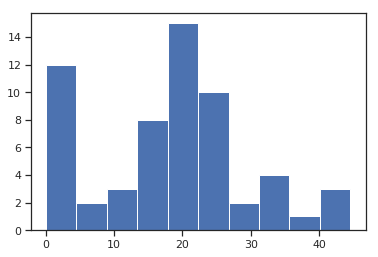

In [59]:
plt.hist(df_result['SL%'])

In [91]:
# Count average number of innings pitched per game, 
# pitches per game, and average number of pitches per inning
df_stats = df_new[date_cols + pitcher_cols + value_cols].groupby(['year'])['ip/gs', 'pitches/gs', 'pitches/ip'].agg('mean')
df_stats

,ip/gs,pitches/gs,pitches/ip
year,,,
2016,6.491062,98.992708,15.271298
2017,6.472589,98.092589,15.173947
2018,6.206214,93.506063,15.149538


In [90]:
# Count percent of pitch types pitched for 2016, 2017, and 2018
df_pMean = df_result.groupby('year').agg('mean')
df_pMean

,FA%,SL%,CT%,CU%,CH%,SP%,KN%,IB%,PI%,UN%
year,,,,,,,,,,
2016,56.3600,17.4110,3.2625,11.7345,10.8875,0.1190,0.0030,0.1755,0.0080,0.038
2017,54.1415,18.8905,3.6980,11.9285,11.1605,0.0290,0.0000,0.0030,0.0075,0.140
2018,51.5385,18.8710,6.3355,11.3525,11.7855,0.0135,0.0015,0.0000,0.0055,0.093


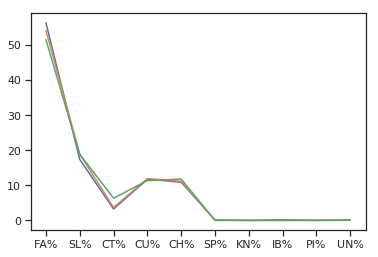

In [62]:
plt.plot(df_pMean.T.index, df_pMean.T)